In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import kaleido
import numpy as np
import scipy.stats as stats

### Importing data
Kaggle Data Source: https://www.kaggle.com/datasets/ananthu017/california-wildfire-incidents-20132020 *originally by https://www.fire.ca.gov/*

In [3]:
DATA_PATH = './data/california_wildfires_2013-2020.csv'

df = pd.read_csv(DATA_PATH, sep=',', encoding='latin-1')

EXPORT_PATH = './export/'

### Getting to know the data
Explaining all variables.

In [4]:
df.columns

Index(['AcresBurned', 'Active', 'AdminUnit', 'AirTankers', 'ArchiveYear',
       'CalFireIncident', 'CanonicalUrl', 'ConditionStatement',
       'ControlStatement', 'Counties', 'CountyIds', 'CrewsInvolved', 'Dozers',
       'Engines', 'Extinguished', 'Fatalities', 'Featured', 'Final',
       'FuelType', 'Helicopters', 'Injuries', 'Latitude', 'Location',
       'Longitude', 'MajorIncident', 'Name', 'PercentContained',
       'PersonnelInvolved', 'Public', 'SearchDescription', 'SearchKeywords',
       'Started', 'Status', 'StructuresDamaged', 'StructuresDestroyed',
       'StructuresEvacuated', 'StructuresThreatened', 'UniqueId', 'Updated',
       'WaterTenders'],
      dtype='object')

Variables of the wildifire dataset:
- **Acres Burned**: Acres of land affected by wildfires
- **Active**: If the fire is active or contained?
- **AdminUnit**: Fire department which is directly assigned to fire
- **AirTankers**: Number of airplane resources assigned
- **ArchiveYear**: Year the data was archived
- **CalFireIncident**: Is the incident treated as a CalFire incident?
- **CanonicalUrl**: Url of record
- **ConditionStatement**: Short report of the wildfire's condition
- **ControlStatement**: Short report of measures and fire control
- **Counties**: Affected County
- **CountyIds**: Affected County ID
- **CrewsInvolved**: Number of firefighter teams assigned
- **Dozers**: Number of dozers assigned
- **Engines**: Number of engines assigned
- **Extinguished**: Date of successful extinguish
- **Fatalities**: Number of fatalities
- **Featured**
- **Final**
- **FuelType**: Type of what material is keeping the fire going (e.g. Grass)
- **Helicopters**: Number of helicopters assigned
- **Injuries**: Count of injured personnel
- **Latitude**: Latitude of wildfire incident
- **Location**: Description of the location
- **Longitude**: Longitude of wildfire incident
- **MajorIncident**: Is the incident considered a major incident?
- **Name**: Name of the wildfire
- **PercentContained**: Percentage of wildfire that is contained
- **PersonnelInvolved**: Number of firefighters involved
- **Public**
- **SearchDescription**: Short description for fire, helping search
- **SearchKeywords**: Keywords, helping search
- **Started**: Fire start date
- **Status**: Status of the fire
- **StructuresDamaged**: Number of structures damaged
- **StructuresDestroyed**: Number of structures completely destroyed
- **StructuresEvacuated**: Number of structures evacuated
- **StructuresThreatened**: Number of structures threatened
- **UniqueId**: Unique identifier for a fire
- **Updated**: Last update date
- **WaterTenders**: Number of water tenders assigned

#### Lets see if there are any variables that aren't expressive & meaningful

In [5]:
# Print variables that are completely null values
null_cols = df.columns[df.isnull().all()]
print('Following columns are completely made up of null values: ',null_cols)

# Drop null_cols
df.drop(null_cols, axis=1, inplace=True)

Following columns are completely made up of null values:  Index(['StructuresEvacuated'], dtype='object')


### Geospatial Analysis
Which counties are most affected by wildfires?

Lets first look at coordinates

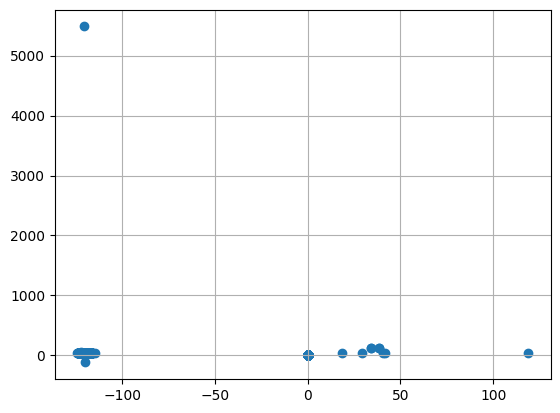

In [6]:
# Check coordinates
plt.scatter(df.Longitude, df.Latitude)
plt.grid()
plt.show()

There are a couple of points which lie outside California's latitude and logitude. So let's remove them.

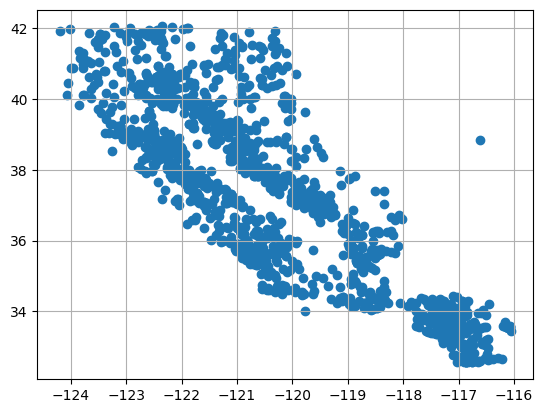

In [7]:
# Remove rows of coordinates which lie outside of California
df_select = df[df.Longitude<-115]
df_select = df_select[(df_select.Latitude<44) & (df_select.Latitude > 30)]
plt.scatter(df_select.Longitude, df_select.Latitude)
plt.grid()
plt.show()

Now we can already see the State of California's shape.
There still seems to be one recorded fire more to the right of California, it looks like it is in Nevada --- Let's look at it.

In [8]:
# Look at the outlier
outlier = df_select[df_select.CanonicalUrl=='/incidents/2013/8/6/tram-fire/']

df.iloc[113]

AcresBurned                                                          60.0
Active                                                              False
AdminUnit                                  San Bernardino National Forest
AirTankers                                                            NaN
ArchiveYear                                                          2013
CalFireIncident                                                     False
CanonicalUrl                               /incidents/2013/8/6/tram-fire/
ConditionStatement                                                    NaN
ControlStatement                                                      NaN
Counties                                                        Riverside
CountyIds                                                              33
CrewsInvolved                                                         NaN
Dozers                                                                NaN
Engines                               

When looking at the latitude and longitude of that row: (Lat: 38.838, Long: -116.61) when using Google Maps, we can see that this location sits in the [middle of Nevada](https://goo.gl/maps/8pcHrJsA5ede2KW28). We can observe that the longitude is correct as it is on the same vertical axis as the Palm Springs Tramway Rd. Through the description of the record we can set the correct latitude from the [location](https://goo.gl/maps/EQvrHKq8cALUURGt9) as 33.845993, -116.611936.

In [9]:
# Set the outliers latitude to 33.845993
df_select.at[113, 'Latitude'] = 33.845993

In [10]:
px.set_mapbox_access_token(token=os.getenv('MAPBOX_ACCESS_TOKEN'))


fig = px.density_mapbox(df_select, lat='Latitude', lon='Longitude', z='AcresBurned', radius=45,
                        center=dict(lat=37.5, lon=-120), zoom=4.7, labels={'Title':'Acres Burned'},
                        opacity=0.6) # for custom mapbox style use os.getenv('MAPBOX_STYLE')

fig.update_layout(
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=0),
    width=800
)

fig.update_coloraxes(colorbar_title='Acres Burned')

# Coordinates for Los Angeles and San Francisco
locations = {
    "Los Angeles": {"lat": 34.0522, "lon": -118.2437},
    "San Francisco": {"lat": 37.7749, "lon": -122.4194}
}

# Add text for Los Angeles and San Francisco
for city, coord in locations.items():
    fig.add_trace(go.Scattermapbox(
        lat=[coord["lat"]],
        lon=[coord["lon"]],
        mode='markers+text',
        marker=go.scattermapbox.Marker(size=0),
        text=[city],
        textposition='middle center',
        textfont=dict(color='white', size=15),
        showlegend=False
    ))

fig.show()

# download figure
fig.write_image("./export/heatmap_1.png")

### Taking a closer look at how months relate to fires

In [11]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from dateutil.parser import parse

# Check if 'Started' is already datetime format
if not is_datetime(df_select['Started']):
    df_select['Started'] = df_select['Started'].apply(parse)

# Extract month and create a new column 'Month', and the same for year
df_select['Month'] = df_select['Started'].dt.month
df_select['Year'] = df_select['Started'].dt.year


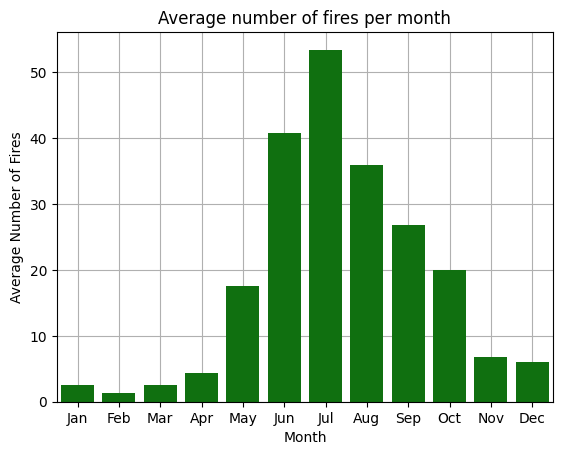

In [12]:
import calendar
import matplotlib.colors as mcolors

# Plot the distribution of fires over the months
month_counts = df_select.groupby('Month')['Year'].value_counts().groupby('Month').mean()

ax = sns.barplot(x=month_counts.index, y=month_counts, zorder=2, color='g')
ax.set_ylabel('Average Number of Fires')
ax.set_title('Average number of fires per month')
#ax.set_label('Month')

# Set x-axis labels to month names
month_names = [calendar.month_abbr[i] for i in range(1, 13)]
plt.xticks(np.arange(12), month_names)

# Enable grid and set zorder to 1 (below bars)
plt.grid(True, zorder=1)

# save figure to export folder
plt.savefig(EXPORT_PATH + 'fires_per_month_barchart.png')

### Taking a general look at correlation

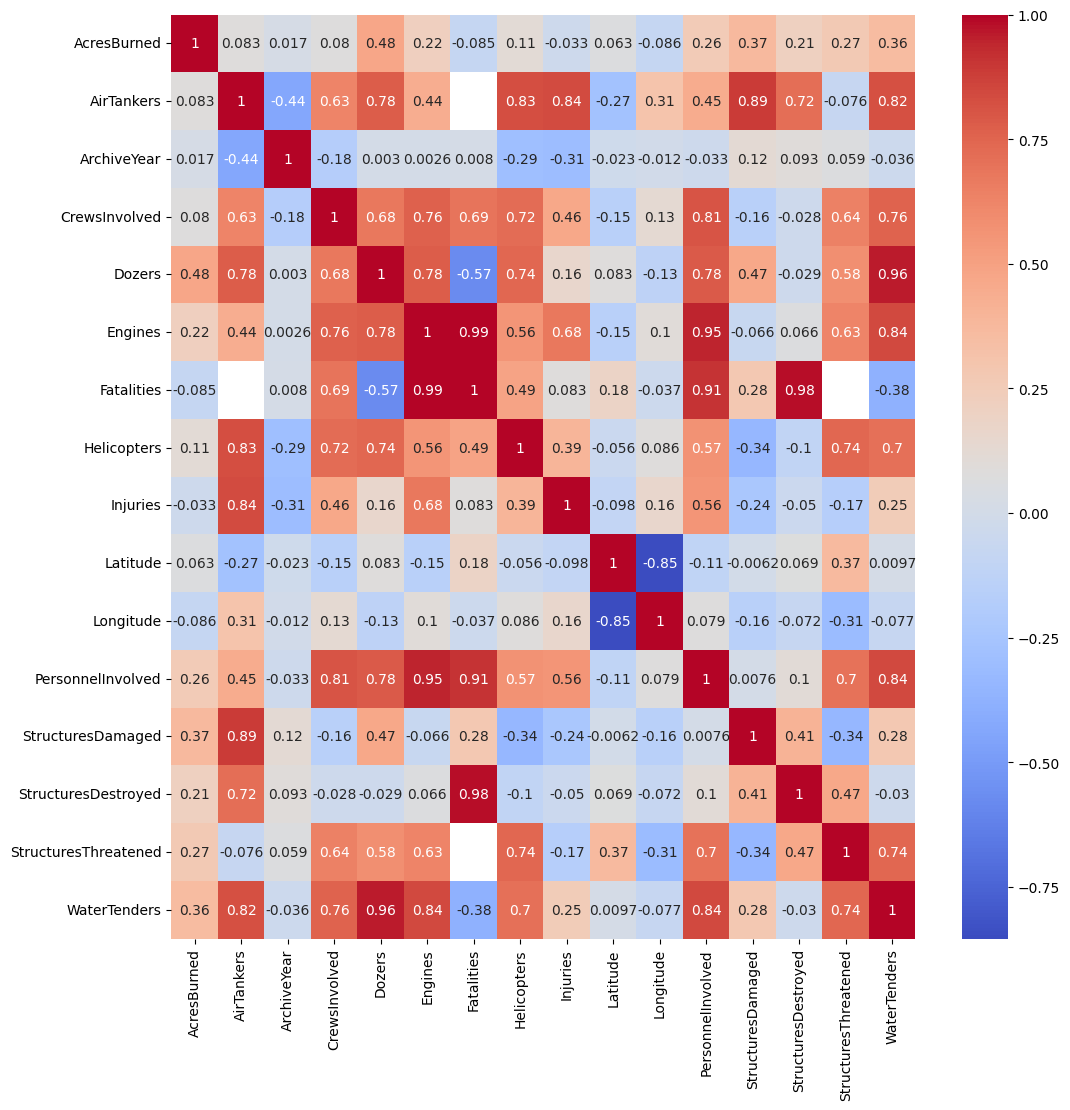

In [13]:
# filter all numerical variables
df_num = df_select.select_dtypes(include=['int64', 'float64'])

df_num.drop('PercentContained', axis=1, inplace=True)

# create correlation matrix
corr_matrix = df_num.corr()

# plot correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Are number of casualties and number of wildfires per County related?

/Users/nils/Documents/Classes/gdv/fhnw-ds-gdv/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10

/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_34501/1007511102.py:40: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



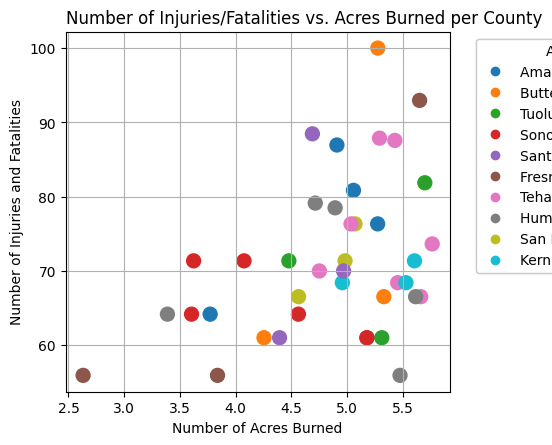

In [87]:
# Group number of wildfires per county
county_counts = np.log10(df_select.groupby('Counties')['AcresBurned'].sum())

# Group number of injuries and fatalities per county
incidents = np.power(df_select.groupby('Counties')['Injuries'].sum() + df_select.groupby('Counties')['Fatalities'].sum(), 1/8)

# scale incidents
incidents = incidents / incidents.max() * 100

# remove counties with no incidents
county_counts = county_counts[incidents > 0]
incidents = incidents[incidents > 0]

from adjustText import adjust_text

# Get admin units for each county
admin_units = df_select.groupby('Counties')['AdminUnit'].agg(lambda x: x.mode()[0])

# Filter relevant admin units
admin_units = admin_units.loc[county_counts.index]
admin_units_cleaned = admin_units.str.replace("CAL FIRE ", "")


# Create a scatter plot of number of wildfires per county vs. number of injuries and fatalities per county
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
scatter = ax.scatter(x=county_counts, y=incidents, s=100, c=pd.Categorical(admin_units).codes, cmap='tab10')
handles, labels = scatter.legend_elements()
admin_unit_legend = ax.legend(handles, admin_units_cleaned.unique(), title="Admin Units", framealpha=1, bbox_to_anchor=(1.05, 1))

# Add the legend to the plot
ax.add_artist(admin_unit_legend)
ax.set_xlabel('Number of Acres Burned')
ax.set_ylabel('Number of Injuries and Fatalities')

ax.set_title('Number of Injuries/Fatalities vs. Acres Burned per County', loc='left')

# Add labels of each county to scatters
plt.grid(True, zorder=1)
plt.tight_layout()
plt.show()

/Users/nils/Documents/Classes/gdv/fhnw-ds-gdv/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10



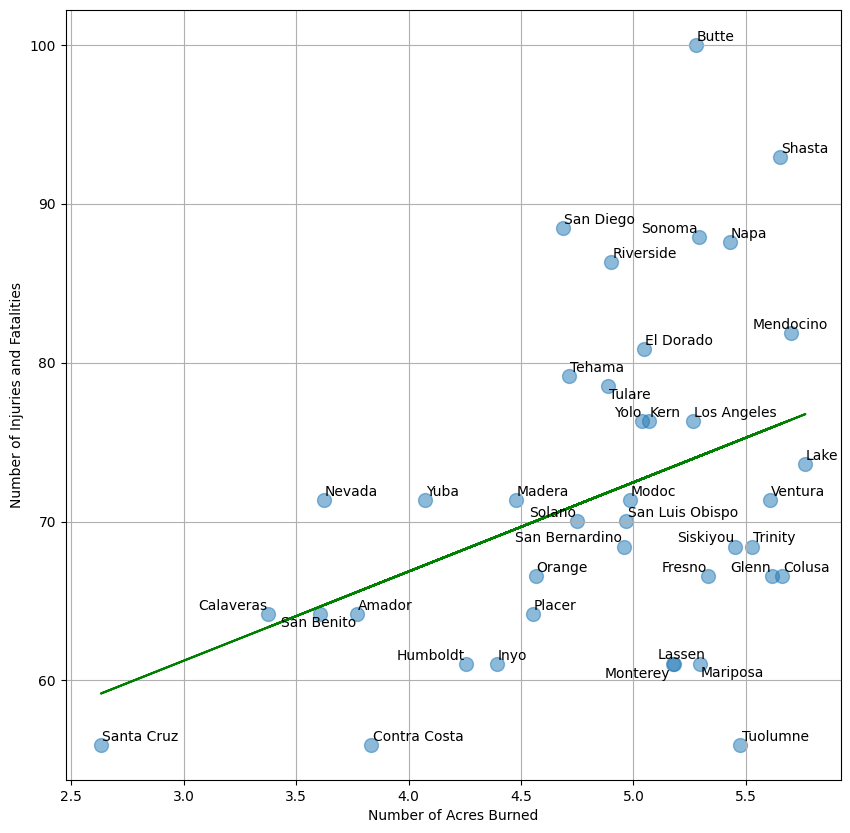

In [38]:
# Group number of wildfires per county
county_counts = np.log10(df_select.groupby('Counties')['AcresBurned'].sum())

# Group number of injuries and fatalities per county
incidents = np.power(df_select.groupby('Counties')['Injuries'].sum() + df_select.groupby('Counties')['Fatalities'].sum(), 1/8)

# scale incidents
incidents = incidents / incidents.max() * 100

# remove counties with no incidents
county_counts = county_counts[incidents > 0]
incidents = incidents[incidents > 0]

from adjustText import adjust_text

# Create a scatter plot of number of wildfires per county vs. number of injuries and fatalities per county
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=county_counts, y=incidents, s=100, alpha=0.5)
ax.set_xlabel('Number of Acres Burned')
ax.set_ylabel('Number of Injuries and Fatalities')

# Add regression line
z = np.polyfit(county_counts, incidents, 1)
p = np.poly1d(z)
plt.plot(county_counts, p(county_counts), "g")


# Add labels of each county to scatters
texts = [plt.text(county_counts[i], incidents[i], txt, fontsize=10) for i, txt in enumerate(county_counts.index)]
adjust_text(texts)
plt.grid(True)

plt.show()

#### The effectiveness of allocated resources

Looking at how long fires lasted vs. number of allocated resources

Relevant variables:
- AirTankers
- CrewsInvolved
- Dozers
- Engines
- Helicopters
- PersonnelInvolved 
- WaterTenders

In [15]:
# Remove rows that have not been extinguished yet
df_select = df_select[df_select['Extinguished'].notnull()]

# Convert 'Extinguished' column to string type
df_select['Extinguished'] = df_select['Extinguished'].astype(str)

# Apply the parse function to convert the string dates to datetime objects
df_select['Extinguished'] = df_select['Extinguished'].apply(lambda x: parse(x) if x != 'nan' else None)

# New variable, describing how long the fire was going on
df_select['DaysLasted'] = (df_select['Extinguished'] - df_select['Started']).dt.days

# New variable, describing how many resources were assigned
df_select['ResourcesAssigned'] = df_select['AirTankers'] + df_select['Helicopters'] + df_select['Dozers'] + df_select['Engines'] + df_select['WaterTenders'] + df_select['PersonnelInvolved']
df_select_res = df_select[df_select['ResourcesAssigned'] > 0]

Text(0, 0.5, 'Resources Used')

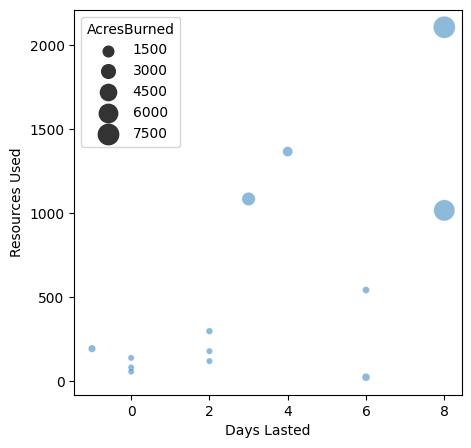

In [16]:
# Plot days lasted vs resources used
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=df_select_res['DaysLasted'], y=df_select_res['ResourcesAssigned'], alpha=0.5, size=df_select_res['AcresBurned'], sizes=(20, 250))
ax.set_xlabel('Days Lasted')
ax.set_ylabel('Resources Used')

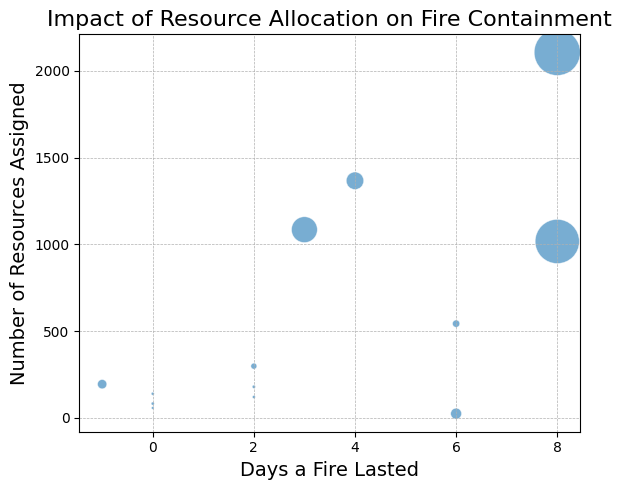

In [17]:

# Prepare the data
x = df_select_res['DaysLasted']
y = df_select_res['ResourcesAssigned']
sizes = df_select_res['AcresBurned']  # This will control the size of the scatter points

# Normalize the sizes to a suitable range for the scatter plot
# You can adjust the scaling factor as necessary for your data
sizes = (sizes / sizes.max()) * 1100  

plt.figure(figsize=(6, 5))

# Create the scatter plot
plt.scatter(x, y, s=sizes, alpha=0.6, edgecolors='w', linewidth=0.5)

# Adding titles and labels with a larger font size
plt.title('Impact of Resource Allocation on Fire Containment', fontsize=16)
plt.xlabel('Days a Fire Lasted', fontsize=14)
plt.ylabel('Number of Resources Assigned', fontsize=14)

# Show grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

#### Looking at how the frequency of fires changed over the years

First off, we need to remove outliers as the set clearly stated the records to be between the year 2013 to 2020.

In [18]:
# Remove wildfires which started before 2013 and after 2020
df_length = len(df_select)
df_select = df_select[df_select['Started'].dt.year >= 2013]
df_select = df_select[df_select['Started'].dt.year < 2021]

print(df_length-len(df_select), 'rows were removed')

2 rows were removed


/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_15230/823316460.py:13: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_15230/823316460.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 1.0, 'Number of Wildfires per Year and Acres Burned per Year')

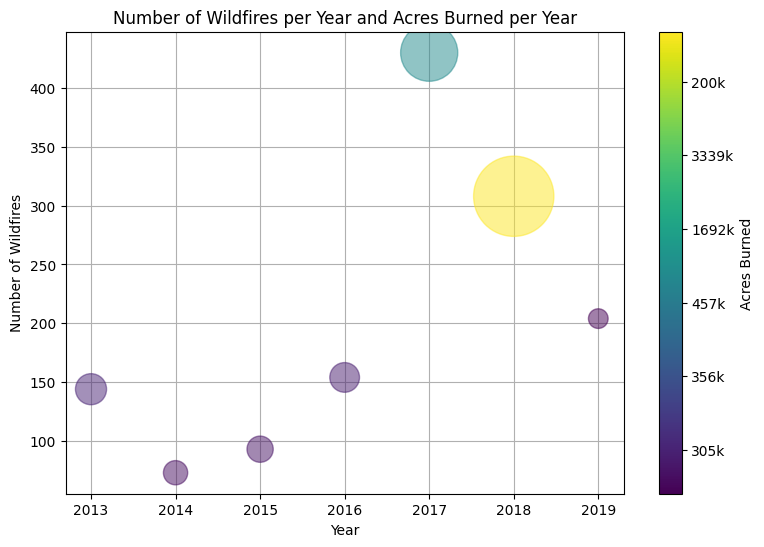

In [19]:
# Number of wildfires per year and acres burned per year
year_counts = df_select['Started'].dt.year.value_counts().sort_index()
year_acres = df_select.groupby(df_select['Started'].dt.year)['AcresBurned'].sum()

# Plot scatter of wildfires per year, scatter dots show acres burned per year
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x=year_counts.index, y=year_counts, s=year_acres/1000, alpha=0.5, c=year_acres, cmap='viridis', zorder=2)
ax.grid(True, zorder=1)

# Add scalar mappable showing acres burned and ticks in thousands with k at the end
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=year_acres.min(), vmax=year_acres.max()))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel('Acres Burned')
cbar.ax.set_yticklabels([str(int(i/1000))+'k' for i in year_acres])

ax.set_xlabel('Year')
ax.set_ylabel('Number of Wildfires')
ax.set_title('Number of Wildfires per Year and Acres Burned per Year')

/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_15230/3846439177.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.85, 0.05, 'r = 0.70')

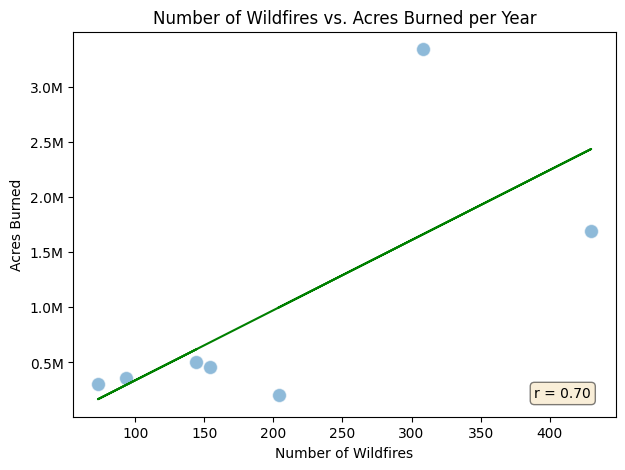

In [20]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plotting scatter of wildfires per year and acres burned per year with seaborn
sns.scatterplot(x=year_counts, y=year_acres, s=100, alpha=0.5)

ax.set_xlabel('Number of Wildfires')
ax.set_ylabel('Acres Burned')

# Set ticks of acres burned to thousands with k at the end
ax.set_yticklabels([str(float(i/1000000))+'M' for i in ax.get_yticks()])
ax.set_title('Number of Wildfires vs. Acres Burned per Year')

# Regression line for acres burned per year
z = np.polyfit(year_counts, year_acres, 1)
p = np.poly1d(z)
plt.plot(year_counts, p(year_counts), "g")

r, p = stats.pearsonr(x=year_counts, y=year_acres)

# Textbox with pearson correlation coefficient
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# annotate the pearson correlation coefficient text to 2 decimal places
plt.text(0.85, 0.05, 'r = {:.2f}'.format(r), transform=ax.transAxes, bbox=props)


/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_15230/1944022565.py:13: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.85, 0.05, 'r = 0.74')

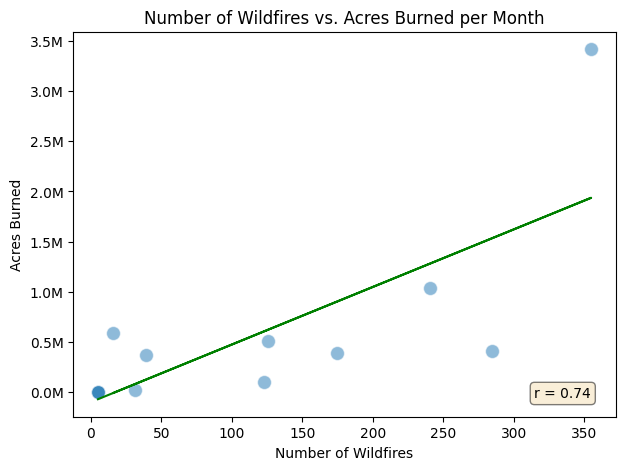

In [21]:
month_counts = df_select['Month'].value_counts().sort_index()
month_acres = df_select.groupby(df_select['Month'])['AcresBurned'].sum()

fig, ax = plt.subplots(figsize=(7, 5))

# Plotting scatter of wildfires per year and acres burned per year with seaborn
sns.scatterplot(x=month_counts, y=month_acres, s=100, alpha=0.5)

ax.set_xlabel('Number of Wildfires')
ax.set_ylabel('Acres Burned')

# Set ticks of acres burned to thousands with k at the end
ax.set_yticklabels([str(float(i/1000000))+'M' for i in ax.get_yticks()])
ax.set_title('Number of Wildfires vs. Acres Burned per Month')

# Regression line for acres burned per year
z = np.polyfit(month_counts, month_acres, 1)
p = np.poly1d(z)
plt.plot(month_counts, p(month_counts), "g")

r, p = stats.pearsonr(x=month_counts, y=month_acres)

# Textbox with pearson correlation coefficient
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# annotate the pearson correlation coefficient text to 2 decimal places
plt.text(0.85, 0.05, 'r = {:.2f}'.format(r), transform=ax.transAxes, bbox=props)

## Violin

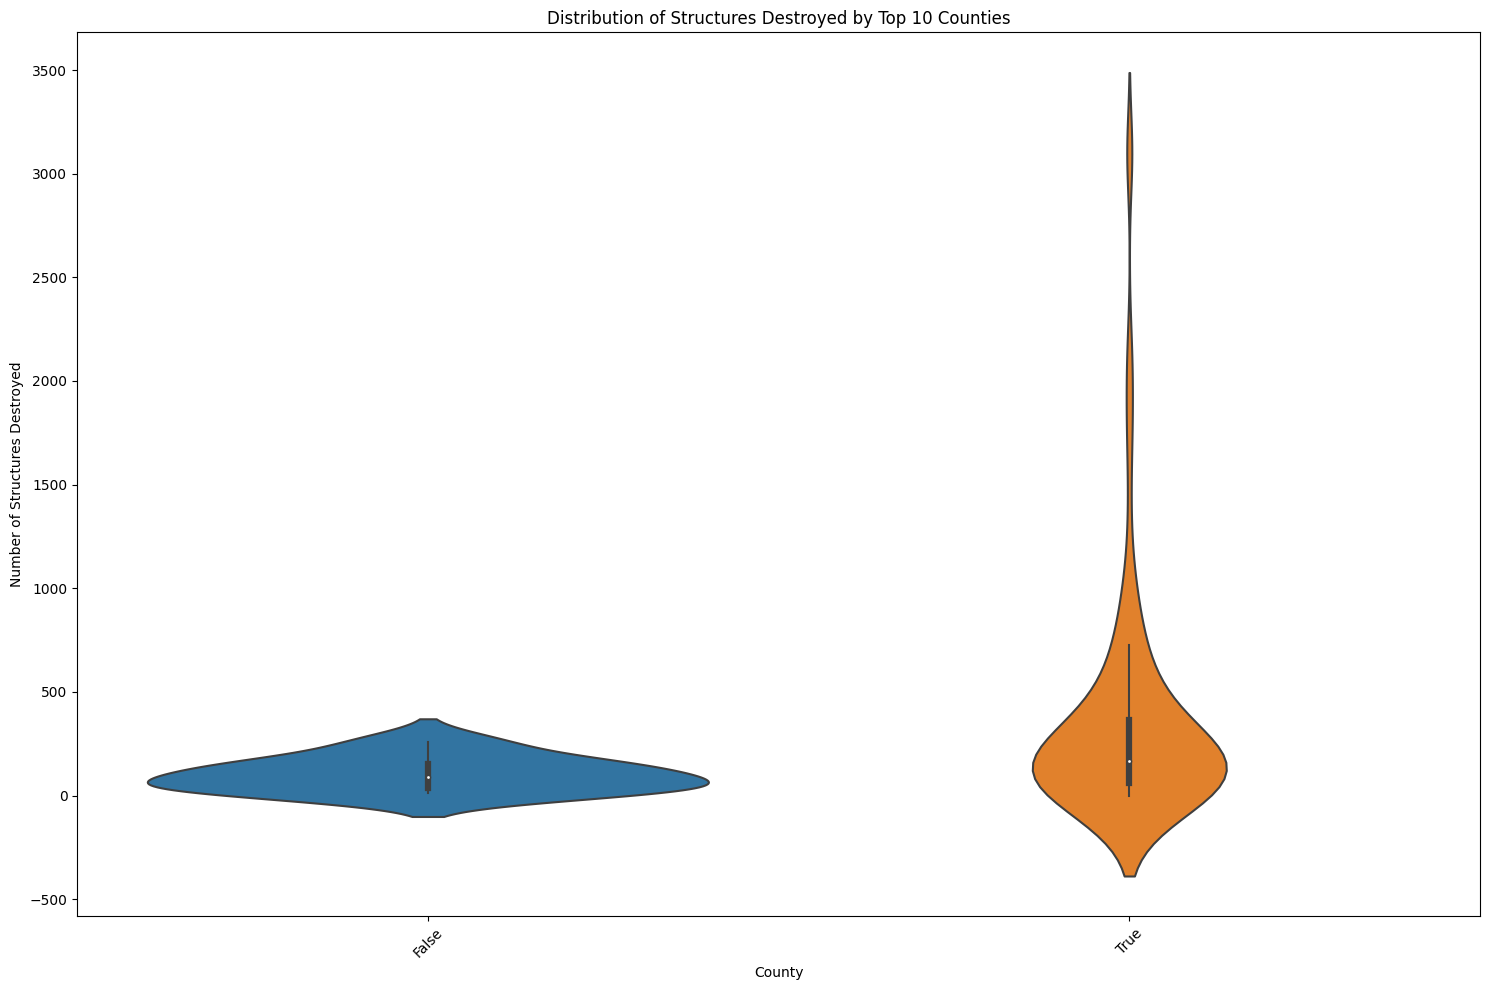

In [22]:
# Creating the violin plot
plt.figure(figsize=(15, 10))
sns.violinplot(x='MajorIncident', y='PersonnelInvolved', data=df_select)
plt.title('Distribution of Structures Destroyed by Top 10 Counties')
plt.ylabel('Number of Structures Destroyed')
plt.xlabel('County')
plt.xticks(rotation=45)  # Adjust the rotation of x-axis labels for better visibility
plt.tight_layout()
plt.show()

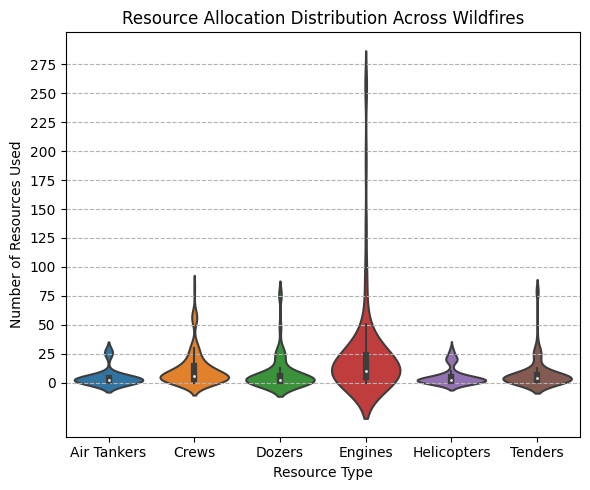

In [23]:
resource_columns = ['AirTankers', 'CrewsInvolved', 'Dozers', 'Engines', 'Helicopters', 'WaterTenders']
renamed_resources = ['Air Tankers', 'Crews', 'Dozers', 'Engines', 'Helicopters', 'Tenders']


# Melting the dataframe to have resource categories and their counts in separate columns
df_melted = df_select.melt(id_vars='AcresBurned', value_vars=resource_columns, 
                                    var_name='Resource', value_name='Count')

plt.figure(figsize=(6, 5))
sns.violinplot(x='Resource', y='Count', data=df_melted, hue='Resource', dodge=False, inner='box')
plt.yticks(range(0, int(df_melted['Count'].max() + 25), 25))  # Setting y-axis ticks in steps of 25
plt.title('Resource Allocation Distribution Across Wildfires')
plt.ylabel('Number of Resources Used')
plt.xlabel('Resource Type')
# rename the x ticks
plt.xticks(range(6), renamed_resources)
#plt.legend(loc='upper right')
# turn off legend
plt.legend().remove()
plt.grid(True, which="both", axis='y', ls="--", c='0.7')
plt.tight_layout()
plt.show()

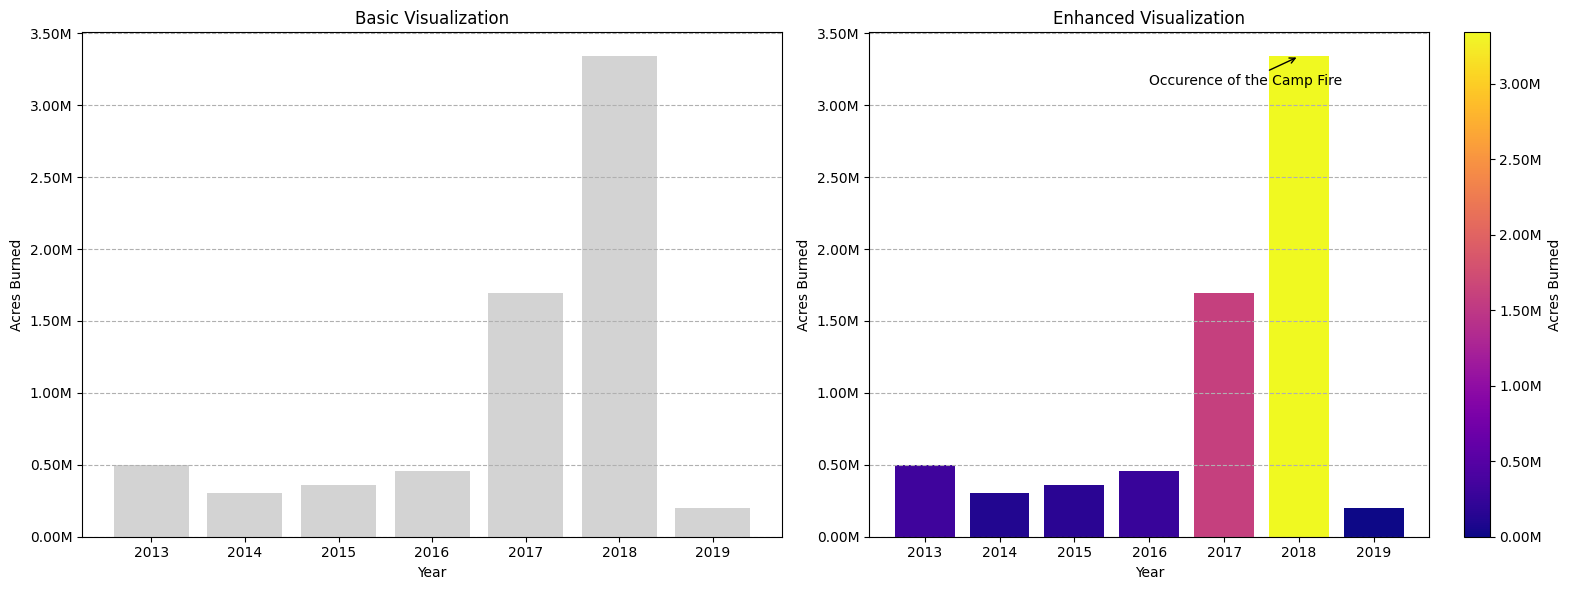

In [24]:
from matplotlib.ticker import FuncFormatter

# Group the data by 'ArchiveYear' and sum the 'AcresBurned' for each year
acres_burned_per_year = df_select.groupby('ArchiveYear')['AcresBurned'].sum()

# Find the year with the maximum acres burned
max_year = acres_burned_per_year.idxmax()
max_acres = acres_burned_per_year.max()

# Function to format the y-axis ticks
def m_formatter(x, pos):
    return f'{(x/1000000):.2f}M'

# Setting up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

from matplotlib.colors import Normalize

# Normalize the acres burned data to the range [0, 1]
norm = Normalize(vmin=acres_burned_per_year.min(), vmax=acres_burned_per_year.max())
colors = [plt.cm.plasma(norm(acres)) for acres in acres_burned_per_year]

# Use the normalized colors for the bar chart
bars = ax2.bar(acres_burned_per_year.index, acres_burned_per_year, color=colors)

# Create a colorbar for the second plot
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(0, acres_burned_per_year.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2)
cbar.set_label('Acres Burned')
cbar.ax.yaxis.set_major_formatter(FuncFormatter(m_formatter))  # Use the same formatter as y-axis
# Plotting the basic visualization on the second axis
ax1.bar(acres_burned_per_year.index, acres_burned_per_year, color='lightgray')
ax1.set_title('Basic Visualization')
ax1.set_xlabel('Year')
ax1.set_ylabel('Acres Burned')
ax1.grid(axis='y', linestyle='--')
ax1.yaxis.set_major_formatter(FuncFormatter(m_formatter))

# Annotations and settings for ax2
ax2.annotate(f'Occurence of the Camp Fire', 
             xy=(max_year, max_acres), 
             xytext=(max_year - 2, max_acres - 200_000), 
             arrowprops=dict(facecolor='black', arrowstyle='->'))
ax2.set_title('Enhanced Visualization')
ax2.set_xlabel('Year')
ax2.set_ylabel('Acres Burned')
ax2.grid(axis='y', linestyle='--')
ax2.yaxis.set_major_formatter(FuncFormatter(m_formatter))

plt.tight_layout()
plt.show()

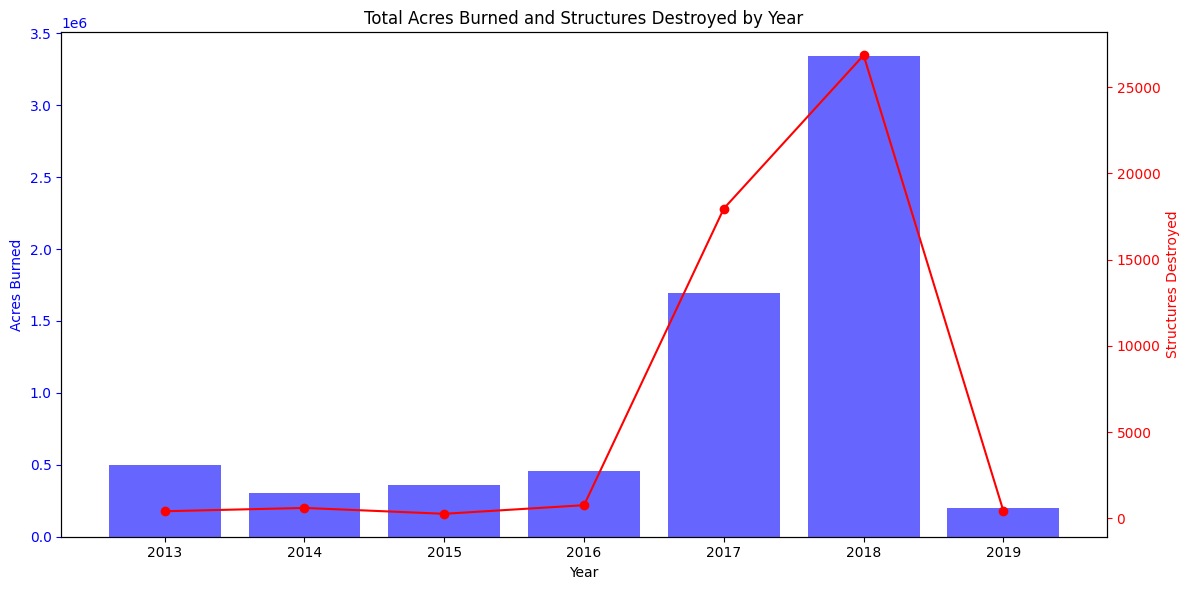

In [25]:
# Grouping by year to get the sum of acres burned and structures destroyed for each year
grouped_data = df_select.groupby('ArchiveYear').agg({'AcresBurned': 'sum', 'StructuresDestroyed': 'sum'}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis for Acres Burned
ax1.bar(grouped_data['ArchiveYear'], grouped_data['AcresBurned'], color='blue', alpha=0.6, label='Acres Burned')
ax1.set_xlabel('Year')
ax1.set_ylabel('Acres Burned', color='blue')
ax1.tick_params('y', colors='blue')

# Secondary y-axis for Structures Destroyed
ax2 = ax1.twinx()
ax2.plot(grouped_data['ArchiveYear'], grouped_data['StructuresDestroyed'], color='red', marker='o', label='Structures Destroyed')
ax2.set_ylabel('Structures Destroyed', color='red')
ax2.tick_params('y', colors='red')

# Setting the title and legend
plt.title('Total Acres Burned and Structures Destroyed by Year')
fig.tight_layout()

plt.show()

In [26]:
df = df_select.copy()

df.columns

Index(['AcresBurned', 'Active', 'AdminUnit', 'AirTankers', 'ArchiveYear',
       'CalFireIncident', 'CanonicalUrl', 'ConditionStatement',
       'ControlStatement', 'Counties', 'CountyIds', 'CrewsInvolved', 'Dozers',
       'Engines', 'Extinguished', 'Fatalities', 'Featured', 'Final',
       'FuelType', 'Helicopters', 'Injuries', 'Latitude', 'Location',
       'Longitude', 'MajorIncident', 'Name', 'PercentContained',
       'PersonnelInvolved', 'Public', 'SearchDescription', 'SearchKeywords',
       'Started', 'Status', 'StructuresDamaged', 'StructuresDestroyed',
       'StructuresThreatened', 'UniqueId', 'Updated', 'WaterTenders', 'Month',
       'Year', 'DaysLasted', 'ResourcesAssigned'],
      dtype='object')

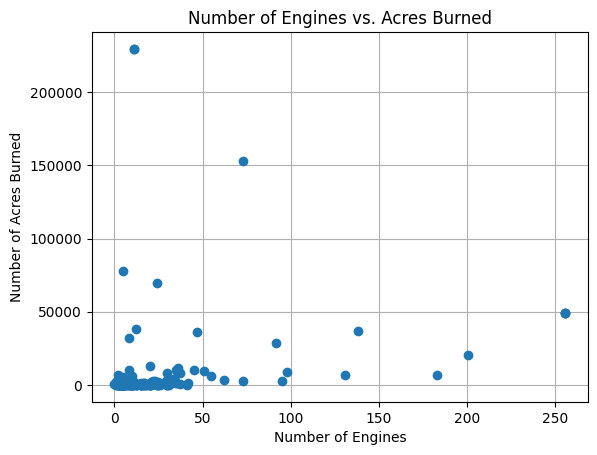

In [27]:
plt.scatter(x=df['Engines'], y=df['AcresBurned'], zorder=3)
plt.title('Number of Engines vs. Acres Burned')
plt.xlabel('Number of Engines')
plt.ylabel('Number of Acres Burned')
plt.grid(True, zorder=2)
plt.show()

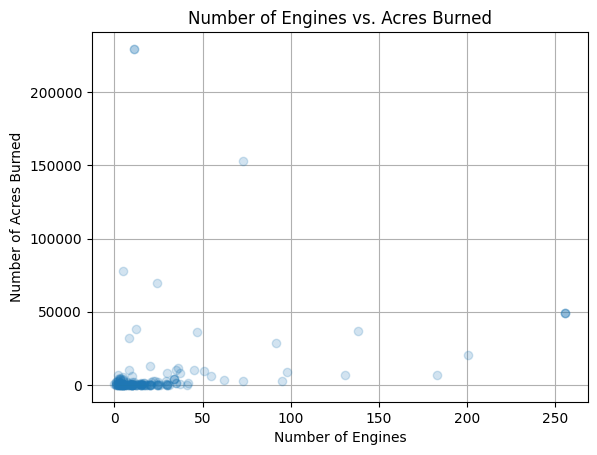

In [28]:
plt.scatter(x=df['Engines'], y=df['AcresBurned'], zorder=3, alpha=0.2)
plt.title('Number of Engines vs. Acres Burned')
plt.xlabel('Number of Engines')
plt.ylabel('Number of Acres Burned')
plt.grid(True, zorder=2)
plt.show()

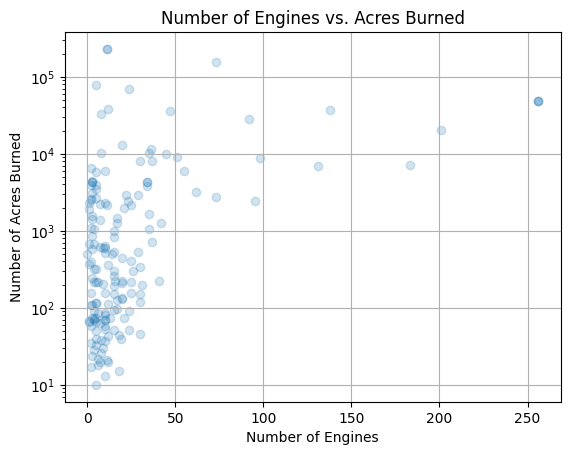

In [29]:
plt.scatter(x=df['Engines'], y=df['AcresBurned'], alpha=0.2)
plt.yscale('log')
plt.title('Number of Engines vs. Acres Burned')
plt.xlabel('Number of Engines')
plt.ylabel('Number of Acres Burned')
plt.grid(True)
plt.show()

In [30]:
# number of fires per county
county_counts = df['Counties'].value_counts()

from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

# only keep counties in california
counties['features'] = [county for county in counties['features'] if county['properties']['STATE'] == '06']

# aggregate only county names and fips codes from counties
county_names = [(county['properties']['NAME'], county['id']) for county in counties['features']]

# Convert county_names into a DataFrame
county_names_df = pd.DataFrame(county_names, columns=['County', 'FIPS'])

# Convert county_counts to a DataFrame and reset index
county_counts_df = county_counts.reset_index()
county_counts_df.columns = ['County', 'Count']

# Merge using a right join to include all counties from county_names_df
merged_df = county_counts_df.merge(county_names_df, on='County', how='right')

# Replace NaN values in 'Count' with 0
merged_df['Count'].fillna(0, inplace=True)

# Ensure FIPS codes are in the correct format (as strings)
merged_df['FIPS'] = merged_df['FIPS'].astype(str)

In [31]:
fig = px.choropleth_mapbox(merged_df, geojson=counties, locations='FIPS', color='Count',
                     title="Frequency of Fires per County<br><sup>From 2013 - 2020</sup>", mapbox_style="mapbox://styles/okaynils/clozudiwf019901o44zug50pe",
                     center=dict(lat=37.5, lon=-119), zoom=4.7,
                     width=700, height=700)

fig.update_traces(hovertemplate='<b>Number of Fires: %{z}')

# update colorbar title
fig.update_layout(coloraxis_colorbar_title='Number of Fires')

fig.update_layout(
    margin=dict(l=30, r=30, t=60, b=30),
    font=dict(size=18)
)